# Réseaux de neurones artificielle avec regularisation HARDER LASSO (ANN HARDER LASSO)
**Aymen.B**

## Théorie

## Dévelopement 

(Je pars de la base pour arriver au modèle finale explicité dans la partie théorie)

In [1]:
import numpy as np
import torch

### Développement d'un modèle de réseaux de neurones avec optimisation Adam manuelle.



#### Ici pas de pénalisation la fonction de cout est simplement MSE.

In [2]:
class ANN(torch.nn.Module):
    def __init__(self, layer_sizes, activation=torch.nn.ReLU, last_activation=None, verbose=False):
        super().__init__()

        self.verbose = verbose
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_f, out_f = layer_sizes[i], layer_sizes[i + 1]
            layers.append(torch.nn.Linear(in_f, out_f))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
            elif last_activation is not None:
                layers.append(last_activation())

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)
    
    def train(self, X, Y, epochs=1000, lr=0.001, loss_fn=None, batch_size=32, shuffle=True, beta1=0.9, beta2=0.999, epsilon=1e-8):
        loss_function = loss_fn or torch.nn.MSELoss()

        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        m = [torch.zeros_like(p) for p in self.parameters()]
        v = [torch.zeros_like(p) for p in self.parameters()]

        t = 0

        for epoch in range(epochs):
            for batch_X, batch_Y in dataloader:
                t += 1

                outputs = self.forward(batch_X)
                loss = loss_function(outputs, batch_Y)
                loss.backward()

                with torch.no_grad():
                    for i, param in enumerate(self.parameters()):
                        if param.grad is None:
                            continue
                        g = param.grad

                        m[i] = beta1 * m[i] + (1 - beta1) * g
                        v[i] = beta2 * v[i] + (1 - beta2) * (g * g)

                        m_hat = m[i] / (1 - beta1 ** t)
                        v_hat = v[i] / (1 - beta2 ** t)

                        param -= lr * m_hat / (v_hat.sqrt() + epsilon)

                self.zero_grad()

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

#### On change de fonction coût on lui rajoute une pénalité multiplié par un coefficient lambda arbitrairement choisi

En théorie il devrait y avoir un souci sur le choix de l'optimiseur mais ce n'est pas un soucis car pytorch reponds à ce problème avec le sous gradient de la norme $\ell_1$ non différentiable en 0

In [3]:
class ANN_Lasso_Adam(torch.nn.Module):
    def __init__(self, layer_sizes, activation=torch.nn.ReLU, last_activation=None, verbose=False):
        super().__init__()

        self.verbose = verbose
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_f, out_f = layer_sizes[i], layer_sizes[i + 1]
            layers.append(torch.nn.Linear(in_f, out_f))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
            elif last_activation is not None:
                layers.append(last_activation())

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)
    
    def train(self,
        X,
        Y,
        epochs=1000,
        lr=0.001,
        loss_fn=None,
        batch_size=32,
        shuffle=True,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        lmbda = 0.1):
        
        loss_function = loss_fn or torch.nn.MSELoss()

        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        m = [torch.zeros_like(p) for p in self.parameters()]
        v = [torch.zeros_like(p) for p in self.parameters()]

        t = 0

        for epoch in range(epochs):
            for batch_X, batch_Y in dataloader:
                t += 1

                outputs = self.forward(batch_X)
                loss = loss_function(outputs, batch_Y)

                if lmbda > 0:
                    l1_penalty = 0.0
                    for name, param in self.named_parameters():
                        if 'weight' in name:  # On évite les biais
                            l1_penalty += torch.norm(param, p=1)
                    loss += lmbda * l1_penalty

                loss.backward()

                with torch.no_grad():
                    for i, param in enumerate(self.parameters()):
                        if param.grad is None:
                            continue
                        g = param.grad

                        m[i] = beta1 * m[i] + (1 - beta1) * g
                        v[i] = beta2 * v[i] + (1 - beta2) * (g * g)

                        m_hat = m[i] / (1 - beta1 ** t)
                        v_hat = v[i] / (1 - beta2 ** t)

                        param -= lr * m_hat / (v_hat.sqrt() + epsilon)

                self.zero_grad()

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

Test de notre code pour voir l'effet de la pénalisation sur les poids !

In [4]:
import matplotlib.pyplot as plt

n = 1000
p = 10
torch.manual_seed(42)
layer_sizes = [10, 3, 1]

X = torch.randn(n, p)

# Seulement les 5 premières dimensions sont utiles s = 5
Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

model_no_reg = ANN_Lasso_Adam(layer_sizes)
model_l1 = ANN_Lasso_Adam(layer_sizes)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

model_no_reg.train(X_train, Y_train, epochs=500, lr=1e-3, lmbda=0.0)
model_l1.train(X_train, Y_train, epochs=500, lr=1e-3, lmbda=1e-2)

def print_weights(model):
    first_layer_weights = None
    for name, param in model.named_parameters():
        if 'weight' in name:
            first_layer_weights = param.detach().clone()
            break
    print("Poids première couche :", np.round(first_layer_weights, 3))
    print("Nombre de poids proches de zéro (< 1e-2) :", (first_layer_weights.abs() < 1e-2).sum().item())

print("🔹 Sans régularisation L1")
print_weights(model_no_reg)

print("\n🔹 Avec régularisation L1")
print_weights(model_l1)


🔹 Sans régularisation L1
Poids première couche : tensor([[ 0.3630, -0.4430, -0.0320,  0.1170, -0.7460,  0.0170, -0.1030, -0.0630,
          0.1580, -0.0410],
        [-0.5310, -0.0160, -0.1300,  0.1940,  0.3900, -0.0140, -0.1990, -0.0500,
          0.2540, -0.0920],
        [ 0.0690, -1.2470,  0.0600, -0.0090, -0.0250,  0.0060,  0.0220, -0.0340,
          0.0230,  0.0150]])
Nombre de poids proches de zéro (< 1e-2) : 2

🔹 Avec régularisation L1
Poids première couche : tensor([[-0.0010,  0.5830, -0.0140, -0.0030,  0.0210, -0.0000, -0.0040,  0.0020,
         -0.0010, -0.0000],
        [-0.4350,  0.0040, -0.0120, -0.0040,  0.6680, -0.0160, -0.0060,  0.0060,
          0.0030, -0.0030],
        [ 0.0010, -0.6610,  0.0070,  0.0020,  0.0020, -0.0020,  0.0010,  0.0000,
          0.0010,  0.0020]])
Nombre de poids proches de zéro (< 1e-2) : 22


IL y a un belle effet de notre pénalisation ! une pénalisation qui à lieu sur tous les poids !

### Développement d'un modèle de réseaux de neurones avec optimisation ISTA et regularisation lasso avec pénalisation de tous les poids.

In [ ]:
class ANN_Lasso_ISTA(torch.nn.Module):
    def __init__(self, layer_sizes, activation=torch.nn.ReLU, last_activation=None, verbose=False):
        super().__init__()
        self.verbose = verbose
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_f, out_f = layer_sizes[i], layer_sizes[i + 1]
            layers.append(torch.nn.Linear(in_f, out_f))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
            elif last_activation is not None:
                layers.append(last_activation())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def soft_threshold(self, z, gamma):
        return torch.sign(z) * torch.maximum(torch.abs(z) - gamma, torch.zeros_like(z))

    def compute_loss(self, outputs, targets, lmbda):
        mse = torch.nn.functional.mse_loss(outputs, targets)
        l1_penalty = sum(torch.norm(p, 1) for name, p in self.named_parameters() if 'weight' in name)
        return mse + lmbda * l1_penalty

    def quadratic_upper_bound(self, y, x, grad, L, fx, lmbda):
        quad = 0.0
        for y_i, x_i, g_i in zip(y, x, grad):
            quad += torch.sum(g_i * (y_i - x_i)) + (L / 2) * torch.norm(y_i - x_i) ** 2 + lmbda * torch.norm(y_i, 1)
        return fx + quad

    def ista_step(self, x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=1.0, eta=2.0):
        L = L_start
        found = False
        while not found:
            gamma = lmbda / L
            y_new = []
            for (name, x, g) in zip([n for n, _ in self.named_parameters()], x_old, grad):
                if 'weight' in name:
                    step = x - (1 / L) * g
                    y_new.append(self.soft_threshold(step, gamma))
                else:
                    y_new.append(x - (1 / L) * g)

            with torch.no_grad():
                for p, y in zip(self.parameters(), y_new):
                    p.copy_(y)

            outputs = self.forward(batch_X)
            F_val = self.compute_loss(outputs, batch_Y, lmbda)
            Q_val = self.quadratic_upper_bound(y_new, x_old, grad, L, fx, lmbda)

            if F_val <= Q_val:
                found = True
            else:
                L *= eta
        return L, F_val

    def train(self, X, Y, epochs=1000, L0=1.0, batch_size=32, shuffle=True, lmbda=0.1, eta=2.0):
        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        L_k = L0

        for epoch in range(epochs):
            for batch_X, batch_Y in dataloader:
                outputs = self.forward(batch_X)
                fx = torch.nn.functional.mse_loss(outputs, batch_Y)

                all_params = list(self.parameters())
                x_old = [p.clone().detach() for p in all_params]
                grad = torch.autograd.grad(fx, all_params, create_graph=False)

                L_k, F_val = self.ista_step(x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=L_k, eta=eta)
                self.zero_grad()

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {F_val.item():.6f}, L_k: {L_k:.4f}")

Comparaison avec un réseau qui utilise Adam. Bien sûr pas grands chose n'est comparable : Adam pénalise même les biais, Ista est plus précis avec un prox explicite. Mais les résultats à attendre sont que ISTA trouvent une loss proche de celle d'adam avec beaucoup plus de paramètres nulles.

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np

n = 1000
p = 10
torch.manual_seed(42)
layer_sizes = [10, 3, 1]

X = torch.randn(n, p)

# Seulement les 5 premières dimensions sont utiles s = 5
Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

model_ista = ANN_Lasso_ISTA(layer_sizes, verbose=True)
model_adam = ANN_Lasso_Adam(layer_sizes, verbose=True)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

print("🔹 Entraînement avec ISTA")
model_ista.train(X_train, Y_train, epochs=1000, L0=1e-4, lmbda=1e-2, shuffle=True, batch_size=1000)
print("🔹 Entraînement avec ADAM")
model_adam.train(X_train, Y_train, epochs=1000, lr=1e-4, lmbda=1e-2, shuffle=True, batch_size=1000)

def print_weights(model):
    first_layer_weights = None
    for name, param in model.named_parameters():
        if 'weight' in name:
            first_layer_weights = param.detach().clone()
            break
    print("Poids première couche :", np.round(first_layer_weights, 3))
    print("Nombre de poids proches de zéro (< 1e-3) :", (first_layer_weights.abs() < 1e-3).sum().item())

print("🔹 Optimisation ISTA")
print_weights(model_ista)

print("🔹 Optimisation ADAM")
print_weights(model_adam)

🔹 Entraînement avec ISTA
Epoch [100/1000], Loss: 0.309999, L_k: 6.5536
Epoch [200/1000], Loss: 0.295137, L_k: 6.5536
Epoch [300/1000], Loss: 0.293031, L_k: 6.5536
Epoch [400/1000], Loss: 0.292413, L_k: 6.5536
Epoch [500/1000], Loss: 0.294899, L_k: 6.5536
Epoch [600/1000], Loss: 0.291777, L_k: 13.1072
Epoch [700/1000], Loss: 0.291582, L_k: 13.1072
Epoch [800/1000], Loss: 0.291432, L_k: 13.1072
Epoch [900/1000], Loss: 0.291332, L_k: 13.1072
Epoch [1000/1000], Loss: 0.291247, L_k: 13.1072
🔹 Entraînement avec ADAM
Epoch [100/1000], Loss: 1.682929
Epoch [200/1000], Loss: 1.647589
Epoch [300/1000], Loss: 1.614174
Epoch [400/1000], Loss: 1.583389
Epoch [500/1000], Loss: 1.553096
Epoch [600/1000], Loss: 1.523164
Epoch [700/1000], Loss: 1.492478
Epoch [800/1000], Loss: 1.461333
Epoch [900/1000], Loss: 1.428978
Epoch [1000/1000], Loss: 1.396872
🔹 Optimisation ISTA
Poids première couche : tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],


Rassurant comme résultat les loss diminue et ista obtiens bien plus de poids nulle que Adam. 1ère remarque ISTA est sensible à un batch size petit et c'est du à la condition de backtracking qui est trop dur à satisfaire avec une aussi grande variance quand le batch est petit. 2eme remarques ISTA convergent très lentement !

### Développement d'un modèle de réseaux de neurones avec optimisation ISTA et regularisation lasso avec pénalisation $\ell_1$ sur la première couche.

In [21]:
class ANN_Lasso(torch.nn.Module):
    def __init__(self, layer_sizes, activation=torch.nn.ReLU, last_activation=None, verbose=False):
        super().__init__()
        self.verbose = verbose
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_f, out_f = layer_sizes[i], layer_sizes[i + 1]
            layer = torch.nn.Linear(in_f, out_f)
            layers.append(layer)
            if i == 0:
                self.first_linear = layer  # On garde la première couche pour la pénalisation
            if i < len(layer_sizes) - 2:
                layers.append(activation())
            elif last_activation is not None:
                layers.append(last_activation())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def soft_threshold(self, z, gamma):
        return torch.sign(z) * torch.maximum(torch.abs(z) - gamma, torch.zeros_like(z))

    def compute_loss(self, outputs, targets, lmbda):
        mse = torch.nn.functional.mse_loss(outputs, targets)
        l1_penalty = torch.norm(self.first_linear.weight, p=1)
        return mse + lmbda * l1_penalty

    def quadratic_upper_bound(self, y, x, grad, L, fx, lmbda):
        quad = 0.0
        for i, (y_i, x_i, g_i) in enumerate(zip(y, x, grad)):
            quad += torch.sum(g_i * (y_i - x_i)) + (L / 2) * torch.norm(y_i - x_i) ** 2
            if i == 0:
                quad += lmbda * torch.norm(y_i, 1)
        return fx + quad

    def ista_step(self, x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=1.0, eta=2.0):
        L = L_start
        found = False
        while not found:
            gamma = lmbda / L
            y_new = []
            
            for i, (x, g) in enumerate(zip(x_old, grad)):
                if i == 0: # Première couche
                    step = x - (1 / L) * g
                    y_new.append(self.soft_threshold(step, gamma))
                else:
                    y_new.append(x - (1 / L) * g)

            with torch.no_grad():
                for p, y in zip(self.parameters(), y_new):
                    p.copy_(y)

            outputs = self.forward(batch_X)
            F_val = self.compute_loss(outputs, batch_Y, lmbda)
            Q_val = self.quadratic_upper_bound(y_new, x_old, grad, L, fx, lmbda)

            if F_val <= Q_val:
                found = True
            else:
                L *= eta
        return L, F_val

    def train(self, X, Y, epochs=1000, L0=1.0, batch_size=32, shuffle=True, lmbda=0.1, eta=2.0):
        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        L_k = L0

        for epoch in range(epochs):
            for batch_X, batch_Y in dataloader:
                outputs = self.forward(batch_X)
                fx = torch.nn.functional.mse_loss(outputs, batch_Y)

                all_params = list(self.parameters())
                x_old = [p.clone().detach() for p in all_params]
                grad = torch.autograd.grad(fx, all_params, create_graph=False)

                L_k, F_val = self.ista_step(x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=L0, eta=eta)
                self.zero_grad()

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {F_val.item():.6f}, L_k: {L_k:.4f}")

Ok je test mon modèle pour m'assurer qu'il converge et fais apparaitre des zeros parmis la première couche.

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np

n = 1000
p = 10
torch.manual_seed(42)
layer_sizes = [10, 3, 1]

X = torch.randn(n, p)

# Seulement les 5 premières dimensions sont utiles s = 5
Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

model_ista = ANN_Lasso(layer_sizes, verbose=True)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

def print_weights(model):
    first_layer_weights = None
    for name, param in model.named_parameters():
        if 'weight' in name:
            first_layer_weights = param.detach().clone()
            break
    print("Poids première couche :", np.round(first_layer_weights, 3))
    print("Nombre de poids proches de zéro dans la première couche (< 1e-3) :", (first_layer_weights.abs() < 1e-3).sum().item())

print("🔹 Avant Optimisation ISTA")
print_weights(model_ista)

print("🔹 Entraînement avec ISTA")
model_ista.train(X_train, Y_train, epochs=1000, L0=1e-4, lmbda=0.01, shuffle=True, batch_size=1000)

print("🔹 Après Optimisation ISTA")
print_weights(model_ista)

weights = model_ista.first_linear.weight.detach()
active_features = (weights.abs() > 1e-4).any(dim=0)
print("🔹 Features activées (<1e-4) :\n", active_features.nonzero(as_tuple=True)[0].tolist())

🔹 Avant Optimisation ISTA
Poids première couche : tensor([[ 0.1710, -0.2630, -0.1900, -0.1850,  0.1670, -0.0110, -0.2900,  0.3100,
          0.0820,  0.2910],
        [ 0.0390,  0.0450,  0.2280, -0.2150,  0.2990, -0.2030,  0.0290, -0.2060,
         -0.2100,  0.2430],
        [-0.0840, -0.0590,  0.2470,  0.3100, -0.2850, -0.0060,  0.0900,  0.3040,
         -0.1260, -0.1030]])
Nombre de poids proches de zéro dans la première couche (< 1e-3) : 0
🔹 Entraînement avec ISTA
Epoch [100/1000], Loss: 0.275648, L_k: 0.8192
Epoch [200/1000], Loss: 0.272402, L_k: 1.6384
Epoch [300/1000], Loss: 0.271973, L_k: 13.1072
Epoch [400/1000], Loss: 0.271575, L_k: 26.2144
Epoch [500/1000], Loss: 0.271209, L_k: 1.6384
Epoch [600/1000], Loss: 0.270905, L_k: 26.2144
Epoch [700/1000], Loss: 0.270677, L_k: 3.2768
Epoch [800/1000], Loss: 0.270510, L_k: 3.2768
Epoch [900/1000], Loss: 0.270368, L_k: 6.5536
Epoch [1000/1000], Loss: 0.270246, L_k: 6.5536
🔹 Après Optimisation ISTA
Poids première couche : tensor([[ 0.00

Top tout ça j'ai eu du mal à l'implémenter surtout pour le calcul de Q qui était mal fais. J'obtiens 3 parmis les 5 features utile c'est plutot bon !
Les L_k ne diverge pas !
La loss diminue donc il apprends il est vivant !

### Développement d'un modèle de réseaux de neurones avec optimisation ISTA et regularisation Square-root lasso avec pénalisation $\ell_1$ sur la première couche.

In [12]:
class ANN_SR_Lasso(torch.nn.Module):
    def __init__(self, layer_sizes, activation=torch.nn.ReLU, last_activation=None, verbose=False):
        super().__init__()
        self.verbose = verbose
        layers = []
        for i in range(len(layer_sizes) - 1):
            in_f, out_f = layer_sizes[i], layer_sizes[i + 1]
            layer = torch.nn.Linear(in_f, out_f)
            layers.append(layer)
            if i == 0:
                self.first_linear = layer
            if i < len(layer_sizes) - 2:
                layers.append(activation())
            elif last_activation is not None:
                layers.append(last_activation())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
    def compute_loss(self, outputs, targets, lmbda):
        sqrt_loss = torch.norm(outputs - targets, p=2)
        l1_penalty = torch.norm(self.first_linear.weight, p=1)
        return sqrt_loss + lmbda * l1_penalty

    def quadratic_upper_bound(self, y_new, x_old, grad, L, fx, lmbda):
        quad = 0.0
        for i, (y_i, x_i, g_i) in enumerate(zip(y_new, x_old, grad)):
            quad += torch.sum(g_i * (y_i - x_i)) + (L / 2) * torch.norm(y_i - x_i) ** 2
            if i == 0:
                quad += lmbda * torch.norm(y_i, 1)
        return fx + quad

    def ista_step(self, x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=1.0, eta=2.0):
        L = L_start

        found = False
        while not found:
            gamma = lmbda / L
            y_new = []
            for i, (x, g) in enumerate(zip(x_old, grad)):
                if i == 0:
                    step = x - (1 / L) * g
                    y_new.append(torch.nn.functional.softshrink(step, lambd=gamma))
                else:
                    y_new.append(x - (1 / L) * g)

            with torch.no_grad():
                for p, y in zip(self.parameters(), y_new):
                    p.copy_(y)

            outputs = self.forward(batch_X)

            F_val = self.compute_loss(outputs, batch_Y, lmbda)
            Q_val = self.quadratic_upper_bound(y_new, x_old, grad, L, fx, lmbda)

            #print(f"F_val: {F_val.item()}, Q_val: {Q_val.item()}, L: {L}")

            if F_val <= Q_val:
                found = True
            else:
                L *= eta
        return L, F_val

    def fit(self, X, Y, epochs=1000, L0=1.0, batch_size=32, shuffle=True, lmbda=0.1, eta=2.0):
        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        
        for epoch in range(epochs):
            for batch_X, batch_Y in dataloader:
                L_k = L0
                outputs = self.forward(batch_X)
                fx = torch.norm(outputs - batch_Y, p=2)  # √Lasso loss (without L1)

                all_params = list(self.parameters())
                x_old = [p.clone().detach() for p in all_params]
                grad = torch.autograd.grad(fx, all_params, create_graph=False)

                #print("New ! Ista step")
                L_k, F_val = self.ista_step(x_old, grad, fx, batch_X, batch_Y, lmbda, L_start=L_k, eta=eta)

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {F_val.item():.6f}, L_k: {L_k:.4f}")

In [27]:
import matplotlib.pyplot as plt
import torch
import numpy as np

n = 1000
p = 10
torch.manual_seed(42)
layer_sizes = [10, 3, 1]

X = torch.randn(n, p)

# Seulement les 5 premières dimensions sont utiles s = 5
Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

model_ista = ANN_SR_Lasso(layer_sizes, verbose=True)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

def print_weights(model):
    first_layer_weights = None
    for name, param in model.named_parameters():
        if 'weight' in name:
            first_layer_weights = param.detach().clone()
            break
    print("Poids première couche :", np.round(first_layer_weights, 3))
    print("Nombre de poids proches de zéro dans la première couche (< 1e-3) :", (first_layer_weights.abs() < 1e-3).sum().item())

print("🔹 Avant Optimisation ISTA")
print_weights(model_ista)

print("🔹 Entraînement avec ISTA")
model_ista.fit(X_train, Y_train, epochs=10000, L0=1, lmbda=0.3, shuffle=True, batch_size=1000)

print("🔹 Après Optimisation ISTA")
print_weights(model_ista)

weights = model_ista.first_linear.weight.detach()
active_features = (weights.abs() > 1e-4).any(dim=0)
print("🔹 Features activées (<1e-4) :\n", active_features.nonzero(as_tuple=True)[0].tolist())

🔹 Avant Optimisation ISTA
Poids première couche : tensor([[ 0.1710, -0.2630, -0.1900, -0.1850,  0.1670, -0.0110, -0.2900,  0.3100,
          0.0820,  0.2910],
        [ 0.0390,  0.0450,  0.2280, -0.2150,  0.2990, -0.2030,  0.0290, -0.2060,
         -0.2100,  0.2430],
        [-0.0840, -0.0590,  0.2470,  0.3100, -0.2850, -0.0060,  0.0900,  0.3040,
         -0.1260, -0.1030]])
Nombre de poids proches de zéro dans la première couche (< 1e-3) : 0
🔹 Entraînement avec ISTA
Epoch [100/10000], Loss: 14.908038, L_k: 1024.0000
Epoch [200/10000], Loss: 14.853792, L_k: 64.0000
Epoch [300/10000], Loss: 14.822049, L_k: 256.0000
Epoch [400/10000], Loss: 14.801093, L_k: 256.0000
Epoch [500/10000], Loss: 14.785966, L_k: 128.0000
Epoch [600/10000], Loss: 14.776273, L_k: 512.0000
Epoch [700/10000], Loss: 14.767251, L_k: 256.0000
Epoch [800/10000], Loss: 14.753124, L_k: 512.0000
Epoch [900/10000], Loss: 14.743493, L_k: 256.0000
Epoch [1000/10000], Loss: 14.728110, L_k: 64.0000
Epoch [1100/10000], Loss: 14

Ok alors là des difficultés à comprendre ce qui n'allait pas pour comprendre que tout vas bien c'est simplement que je comparer avec avant sauf que pour le lasso c'est MSE qui est utilisé donc Rien à voir avec la square root. Mais résultant me semble satisfaisant il y a bien une sélection de variable pour un lambda suffisament grand.

### Développement propre d'un modèle de réseaux de neurones avec optimisation ISTA et regularisation Square-root lasso avec pénalisation $\ell_1$ sur la première couche.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


class AnnSRLasso(nn.Module):
    def __init__(self, sizes, activation=nn.ReLU, last_activation=None, verbose=False):
        super().__init__()
        self.verbose = verbose
        
        layers = []
        for i in range(len(sizes) - 1):
            layer = nn.Linear(sizes[i], sizes[i + 1])
            layers.append(layer)
            
            if i == 0:
                self.first_layer = layer
            
            if i < len(sizes) - 2:
                layers.append(activation())
            elif last_activation:
                layers.append(last_activation())
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
    def compute_loss(self, out, targets, lmbda):
        mse = torch.norm(out - targets, p=2)
        l1_reg = torch.norm(self.first_layer.weight, p=1)
        return mse + lmbda * l1_reg

    def quad_bound(self, y_new, x_old, grad, L, fx, lmbda):
        quad = 0.0
        for i, (y, x, g) in enumerate(zip(y_new, x_old, grad)):
            quad += torch.sum(g * (y - x)) + (L / 2) * torch.norm(y - x) ** 2
            if i == 0:
                quad += lmbda * torch.norm(y, 1)
        return fx + quad

    def ista_step(self, x_old, grad, fx, batch_x, batch_y, lmbda, L_start=1.0, eta=2.0):
        L = L_start
        
        while True:
            gamma = lmbda / L
            y_new = []
            
            for i, (x, g) in enumerate(zip(x_old, grad)):
                if i == 0:
                    step = x - (1 / L) * g
                    y_new.append(F.softshrink(step, lambd=gamma))
                else:
                    y_new.append(x - (1 / L) * g)

            with torch.no_grad():
                for p, y in zip(self.parameters(), y_new):
                    p.copy_(y)

            out = self.forward(batch_x)
            F_val = self.compute_loss(out, batch_y, lmbda)
            Q_val = self.quad_bound(y_new, x_old, grad, L, fx, lmbda)

            if F_val <= Q_val:
                return L, F_val
            
            L *= eta

    def fit(self, X, Y, epochs=1000, L0=1.0, batch_size=None, shuffle=True, lmbda=0.1, eta=2.0):
        if batch_size is None:
            batch_size = len(X)
        dataset = TensorDataset(X, Y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        
        for epoch in range(epochs):
            for batch_x, batch_y in loader:
                L_k = L0
                out = self.forward(batch_x)
                fx = torch.norm(out - batch_y, p=2)

                params = list(self.parameters())
                x_old = [p.clone().detach() for p in params]
                grad = torch.autograd.grad(fx, params, create_graph=False)

                L_k, F_val = self.ista_step(x_old, grad, fx, batch_x, batch_y, lmbda, L_start=L_k, eta=eta)

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {F_val.item():.6f}, L_k: {L_k:.4f}")

In [59]:
import torch
import numpy as np

n, p = 1000, 10
torch.manual_seed(42)
X = torch.randn(n, p)

Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

model = AnnSRLasso([p, 3, 1], verbose=True)

def print_weights(model):
    w = model.first_layer.weight.detach().cpu().numpy()
    print("Poids première couche :", np.round(w, 3))
    print("Nombre de poids proches de zéro (< 1e-3) :", (np.abs(w) < 1e-3).sum())

print("🔹 Avant Optimisation ISTA")
print_weights(model)

print("🔹 Entraînement avec ISTA")
model.fit(X_train, Y_train, epochs=1000, L0=1.0, lmbda=0.3)

print("🔹 Après Optimisation ISTA")
print_weights(model)

w = model.first_layer.weight.detach()
active = (w.abs() > 1e-4).any(dim=0)
print("🔹 Features activées (<1e-4) :", active.nonzero(as_tuple=True)[0].tolist())


🔹 Avant Optimisation ISTA
Poids première couche : [[ 0.171 -0.263 -0.19  -0.185  0.167 -0.011 -0.29   0.31   0.082  0.291]
 [ 0.039  0.045  0.228 -0.215  0.299 -0.203  0.029 -0.206 -0.21   0.243]
 [-0.084 -0.059  0.247  0.31  -0.285 -0.006  0.09   0.304 -0.126 -0.103]]
Nombre de poids proches de zéro (< 1e-3) : 0
🔹 Entraînement avec ISTA
Epoch [100/1000], Loss: 3.255974, L_k: 64.0000
Epoch [200/1000], Loss: 3.228405, L_k: 64.0000
Epoch [300/1000], Loss: 2.418235, L_k: 64.0000
Epoch [400/1000], Loss: 3.098960, L_k: 64.0000
Epoch [500/1000], Loss: 3.436137, L_k: 64.0000
Epoch [600/1000], Loss: 2.829231, L_k: 64.0000
Epoch [700/1000], Loss: 2.999206, L_k: 128.0000
Epoch [800/1000], Loss: 3.303372, L_k: 128.0000
Epoch [900/1000], Loss: 2.728492, L_k: 64.0000
Epoch [1000/1000], Loss: 3.102011, L_k: 64.0000
🔹 Après Optimisation ISTA
Poids première couche : [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.292 -0.046 -0.001 -0.031  0.656 -0.058  0.013  0.027  0.02 

### Développement Modèle LASSO ANN de l'article

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


class LASSOANN(nn.Module):
    def __init__(self, sizes, activation=nn.ELU, last_activation=None, verbose=False):
        super().__init__()
        self.verbose = verbose

        layers = []
        for i in range(len(sizes) - 1):
            layer = nn.Linear(sizes[i], sizes[i + 1])
            layers.append(layer)

            if i == 0:
                self.first_layer = layer

            if i < len(sizes) - 2:
                layers.append(activation())
            elif last_activation:
                layers.append(last_activation())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def compute_loss(self, out, targets, lmbda):
        residual = torch.norm(out - targets, p=2)
        l1_reg = torch.norm(self.first_layer.weight, p=1)
        return residual + lmbda * l1_reg

    def lambda_qut(self, X, M=1000, alpha=0.05, seed=None, sigma_deriv_0=1.0, pi_l=1.0):
        if seed is not None:
            torch.manual_seed(seed)

        n = X.shape[0]
        Lambda = []
        for _ in range(M):
            Y_sim = torch.randn(n, device=X.device)
            denom = torch.norm(Y_sim, p=2)
            if denom == 0:
                continue
            lam0 = torch.norm(X.T @ Y_sim / denom, p=float('inf'))
            Lambda.append(lam0.item())

        lam_qut = pi_l * sigma_deriv_0 * torch.tensor(Lambda).quantile(1 - alpha).item()
        return lam_qut

    def quad_bound(self, y_new, x_old, grad, L, fx, lmbda):
        quad = 0.0
        for i, (y, x, g) in enumerate(zip(y_new, x_old, grad)):
            quad += torch.sum(g * (y - x)) + (L / 2) * torch.norm(y - x) ** 2
            if i == 0:
                quad += lmbda * torch.norm(y, 1)
        return fx + quad

    def ista_step(self, x_old, grad, fx, batch_x, batch_y, lmbda, L_start=1.0, eta=2.0):
        L = L_start

        while True:
            gamma = lmbda / L
            y_new = []

            for i, (x, g) in enumerate(zip(x_old, grad)):
                if i == 0:
                    step = x - (1 / L) * g
                    y_new.append(F.softshrink(step, lambd=gamma))
                else:
                    y_new.append(x - (1 / L) * g)

            with torch.no_grad():
                for p, y in zip(self.parameters(), y_new):
                    p.copy_(y)

            out = self.forward(batch_x)
            F_val = self.compute_loss(out, batch_y, lmbda)
            Q_val = self.quad_bound(y_new, x_old, grad, L, fx, lmbda)

            if F_val <= Q_val:
                return L, F_val

            L *= eta

    def fit(self, X, Y, epochs=1000, L0=1.0, batch_size=None, shuffle=True, lmbda=0.1, eta=2.0):
        if batch_size is None:
            batch_size = len(X)
        dataset = TensorDataset(X, Y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        L_k = L0

        for epoch in range(epochs):
            for batch_x, batch_y in loader:
                
                out = self.forward(batch_x)
                fx = torch.norm(out - batch_y, p=2)

                params = list(self.parameters())
                x_old = [p.clone().detach() for p in params]
                grad = torch.autograd.grad(fx, params, create_graph=False)

                L_k, F_val = self.ista_step(x_old, grad, fx, batch_x, batch_y, lmbda, L_start=L_k, eta=eta)

            if self.verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {F_val.item():.6f}, L_k: {L_k:.4f}")

In [2]:
import torch
import numpy as np

n, p = 1000, 10
torch.manual_seed(42)
X = torch.randn(n, p)

Y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])**2 + 0.3 * X[:, 2] * X[:, 3] - X[:, 4]
Y = Y.unsqueeze(1)

X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

model = LASSOANN([p, 3, 1], verbose=True)

def print_weights(model):
    w = model.first_layer.weight.detach().cpu().numpy()
    print("Poids première couche :", np.round(w, 3))
    print("Nombre de poids proches de zéro (< 1e-3) :", (np.abs(w) < 1e-3).sum())

print("🔹 Avant Optimisation ISTA")
print_weights(model)

print("🔹 Entraînement avec ISTA")
lambda_qut = model.lambda_qut(X, M=1000, alpha=0.05)
model.fit(X, Y, lmbda=lambda_qut, epochs=1000, L0=1.0, shuffle=True, batch_size=None)


print("🔹 Après Optimisation ISTA")
print("Lambda QUT :", lambda_qut)
print_weights(model)

w = model.first_layer.weight.detach()
active = (w.abs() > 1e-4).any(dim=0)
print("🔹 Features activées (<1e-4) :", active.nonzero(as_tuple=True)[0].tolist())

🔹 Avant Optimisation ISTA
Poids première couche : [[ 0.171 -0.263 -0.19  -0.185  0.167 -0.011 -0.29   0.31   0.082  0.291]
 [ 0.039  0.045  0.228 -0.215  0.299 -0.203  0.029 -0.206 -0.21   0.243]
 [-0.084 -0.059  0.247  0.31  -0.285 -0.006  0.09   0.304 -0.126 -0.103]]
Nombre de poids proches de zéro (< 1e-3) : 0
🔹 Entraînement avec ISTA
Epoch [100/1000], Loss: 18.897556, L_k: 256.0000
Epoch [200/1000], Loss: 18.460762, L_k: 256.0000
Epoch [300/1000], Loss: 18.278563, L_k: 512.0000
Epoch [400/1000], Loss: 18.195658, L_k: 512.0000
Epoch [500/1000], Loss: 18.127386, L_k: 512.0000
Epoch [600/1000], Loss: 18.069847, L_k: 512.0000
Epoch [700/1000], Loss: 18.020458, L_k: 512.0000
Epoch [800/1000], Loss: 17.977440, L_k: 512.0000
Epoch [900/1000], Loss: 17.939453, L_k: 512.0000
Epoch [1000/1000], Loss: 17.905497, L_k: 512.0000
🔹 Après Optimisation ISTA
Lambda QUT : 2.7963171005249023
Poids première couche : [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.185  0.  

#### Test de l'article

In [3]:
import numpy as np

def generate_data_nonlinear(n=500, p=50, h=5, noise_std=0.1, seed=None):
    """
    Génère des données simulées pour le test non linéaire de l’article.
    
    - μ(x) = ∑_{i=1}^h 10 * |x_{2i} - x_{2i - 1}|
    - Support S* = {0, 1, ..., 2h - 1}
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(0, 1, size=(n, p))
    
    y = np.zeros(n)
    for i in range(1, h + 1):
        j1, j2 = 2 * i - 2, 2 * i - 1  # indices des variables utilisées
        y += 10 * np.abs(X[:, j2] - X[:, j1])
    
    y += rng.normal(0, noise_std, size=n)
    
    S_true = set(range(2 * h))  # Les colonnes 0 à 2h - 1
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).reshape(-1, 1), S_true

In [4]:
def get_active_variables(W1: torch.Tensor, eps: float = 1e-5) -> set:
    """
    Retourne l’ensemble des indices j tels que la colonne j de W1 est active.
    """
    return {j for j in range(W1.shape[1]) if torch.norm(W1[:, j]) > eps}

def pesr(W1: torch.Tensor, S_true: set, eps: float = 0.0) -> float:
    """
    Calcule la PESR : 1 si S_hat == S_true, sinon 0.
    
    Args:
        S_hat (set): ensemble des variables sélectionnées
        S_true (set): ensemble des vraies variables pertinentes

    Returns:
        float: 1.0 si exact recovery, 0.0 sinon
    """
    S_hat = get_active_variables(W1, eps)
    return float(S_hat == S_true)

def f1_score(S_hat: set, S_true: set) -> float:
    TP = np.sum([1 for i in S_true if i in S_hat])
    FP = np.sum([1 for i in S_hat if i not in S_true])
    FN = np.sum([1 for i in S_true if i not in S_hat])
    denom = 2 * TP + FP + FN
    return 2 * TP / denom if denom > 0 else 0.0

In [5]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS NON LINEAIRE\OUTILS")

|X| h = 0
|XXX| Simu = 0
|XXX| Simu = 1
|XXX| Simu = 2
|XXX| Simu = 3
|XXX| Simu = 4
|XXX| Simu = 5
|XXX| Simu = 6
|XXX| Simu = 7
|XXX| Simu = 8
|XXX| Simu = 9
|XXX| Simu = 10
|XXX| Simu = 11
|XXX| Simu = 12
|XXX| Simu = 13
|XXX| Simu = 14
|XXX| Simu = 15
|XXX| Simu = 16
|XXX| Simu = 17
|XXX| Simu = 18
|XXX| Simu = 19
|XXX| Simu = 20
|XXX| Simu = 21
|XXX| Simu = 22
|XXX| Simu = 23
|XXX| Simu = 24
|XXX| Simu = 25
|XXX| Simu = 26
|XXX| Simu = 27
|XXX| Simu = 28
|XXX| Simu = 29
|XXX| Simu = 30
|XXX| Simu = 31
|XXX| Simu = 32
|XXX| Simu = 33
|XXX| Simu = 34
|XXX| Simu = 35
|XXX| Simu = 36
|XXX| Simu = 37
|XXX| Simu = 38
|XXX| Simu = 39
|XXX| Simu = 40
|XXX| Simu = 41
|XXX| Simu = 42
|XXX| Simu = 43
|XXX| Simu = 44
|XXX| Simu = 45
|XXX| Simu = 46
|XXX| Simu = 47
|XXX| Simu = 48
|XXX| Simu = 49
|XXX| Simu = 50
|XXX| Simu = 51
|XXX| Simu = 52
|XXX| Simu = 53
|XXX| Simu = 54
|XXX| Simu = 55
|XXX| Simu = 56
|XXX| Simu = 57
|XXX| Simu = 58
|XXX| Simu = 59
|XXX| Simu = 60
|XXX| Simu = 61
|XXX| Si

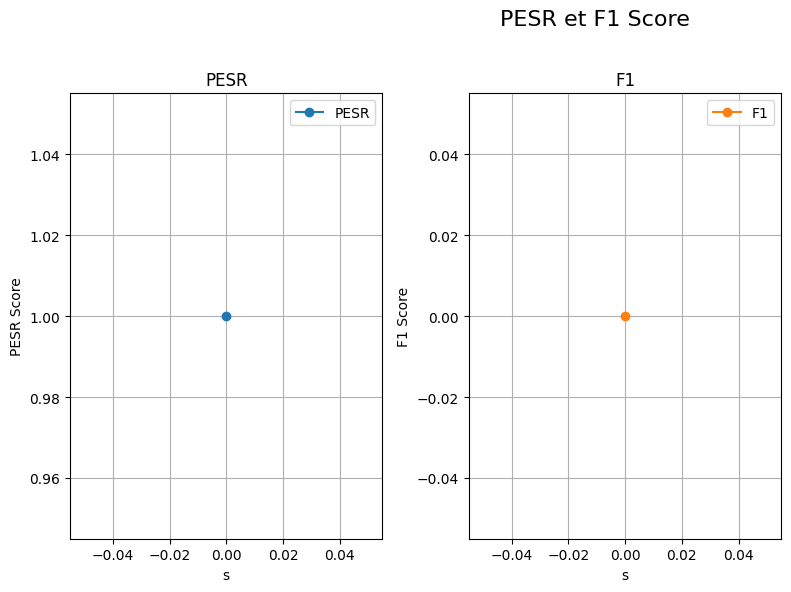

In [8]:
from non_linear_tools import plot_scores
scores = {'pesr': [], 'f1': []}
s_range = []

simu_iter = 100
seed = 42

for h in [0]:
    n, p = 500, 50
    s = 2 * h
    pesr_list = []
    f1_list = []
    print(f"|X| h = {h}")
    for i in range(simu_iter):
        print(f"|XXX| Simu = {i}")
        X, y, S_true = generate_data_nonlinear(n, p, h=h, seed=seed * i)
        model = LASSOANN(sizes=[50, 20, 1], verbose=False)
        lmbda = model.lambda_qut(X, M=1000, alpha=0.05)
        model.fit(X, y, lmbda=lmbda, epochs=50, L0=0.5)
        W1 = model.first_layer.weight.detach()
        S_hat = get_active_variables(W1)
        pesr_list.append(pesr(W1, S_true))
        f1_list.append(f1_score(S_hat, S_true))
    scores['pesr'].append(np.mean(pesr_list))
    scores['f1'].append(np.mean(f1_list))
    s_range.append(s)

plot_scores(scores, s_range, "PESR et F1 Score")


Ok je m'arrete là niveau réseau j'ai pas exacctement les memes résultat mais c'est bon. Une erreur dans mon F1 score dailleurs qui fais que monter pfff